In [ ]:
!pip install datasets timm tqdm torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import models, transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os
from PIL import Image
import timm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_dataset_path = "/content/drive/MyDrive/deepfake/train"
val_dataset_path = "/content/drive/MyDrive/deepfake/val"
test_dataset_path = "/content/drive/MyDrive/deepfake/test"

In [ ]:
class DeepfakeDataset(Dataset):
   def __init__(self, root_dir, transform=None):
       self.root_dir = root_dir
       self.transform = transform
       self.images = []
       self.labels = []

       real_dir = os.path.join(root_dir, 'real')
       for img_name in os.listdir(real_dir):
           if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
               self.images.append(os.path.join(real_dir, img_name))
               self.labels.append(0)

       fake_dir = os.path.join(root_dir, 'fake')
       for img_name in os.listdir(fake_dir):
           if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
               self.images.append(os.path.join(fake_dir, img_name))
               self.labels.append(1)

   def __len__(self):
       return len(self.images)

   def __getitem__(self, idx):
       img_path = self.images[idx]
       image = Image.open(img_path).convert('RGB')
       label = self.labels[idx]

       if self.transform:
           image = self.transform(image)
       return image, label

def train_model():
   BATCH_SIZE = 16
   EPOCHS = 10
   LEARNING_RATE = 0.0001

   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   print(f"Using device: {device}")

   transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Resize((224, 224), antialias=True),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ])

   train_dataset = DeepfakeDataset(root_dir=train_dataset_path, transform=transform)
   val_dataset = DeepfakeDataset(root_dir=val_dataset_path, transform=transform)
   test_dataset = DeepfakeDataset(root_dir=test_dataset_path, transform=transform)

   train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
   val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
   test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

   model = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.IMAGENET1K_V1)
   model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
   model = model.to(device)

   criterion = nn.CrossEntropyLoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

   best_val_acc = 0.0
   train_losses, val_losses = [], []
   train_accs, val_accs = [], []

   for epoch in range(EPOCHS):
       print(f"\nEpoch {epoch+1}/{EPOCHS}")

       # Training
       model.train()
       train_loss = 0
       train_correct = 0
       train_total = 0

       for images, labels in tqdm(train_loader, desc="Training"):
           images, labels = images.to(device), labels.to(device)

           optimizer.zero_grad()
           outputs = model(images)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()

           train_loss += loss.item()
           _, predicted = torch.max(outputs.data, 1)
           train_total += labels.size(0)
           train_correct += (predicted == labels).sum().item()

       epoch_train_loss = train_loss/len(train_loader)
       epoch_train_acc = 100 * train_correct / train_total
       train_losses.append(epoch_train_loss)
       train_accs.append(epoch_train_acc)

       print(f'Training Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.2f}%')

       # Validation
       model.eval()
       val_loss = 0
       val_correct = 0
       val_total = 0

       with torch.no_grad():
           for images, labels in tqdm(val_loader, desc="Validation"):
               images, labels = images.to(device), labels.to(device)
               outputs = model(images)
               loss = criterion(outputs, labels)
               val_loss += loss.item()

               _, predicted = torch.max(outputs.data, 1)
               val_total += labels.size(0)
               val_correct += (predicted == labels).sum().item()

       epoch_val_loss = val_loss/len(val_loader)
       epoch_val_acc = 100 * val_correct / val_total
       val_losses.append(epoch_val_loss)
       val_accs.append(epoch_val_acc)

       print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%')
       scheduler.step(epoch_val_loss)

       # Plot metrics
       plt.figure(figsize=(12, 4))
       plt.subplot(1, 2, 1)
       plt.plot(train_losses, label='Training Loss')
       plt.plot(val_losses, label='Validation Loss')
       plt.title('Losses over epochs')
       plt.xlabel('Epoch')
       plt.ylabel('Loss')
       plt.legend()

       plt.subplot(1, 2, 2)
       plt.plot(train_accs, label='Training Accuracy')
       plt.plot(val_accs, label='Validation Accuracy')
       plt.title('Accuracies over epochs')
       plt.xlabel('Epoch')
       plt.ylabel('Accuracy (%)')
       plt.legend()

       plt.tight_layout()
       plt.savefig(f'training_metrics_epoch_{epoch}.png')
       plt.close()

       if epoch_val_acc > best_val_acc:
           best_val_acc = epoch_val_acc
           torch.save({
               'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'val_acc': epoch_val_acc,
           }, 'efficientnet_b7_best_model.pth')
           print(f'Saved new best model with validation accuracy: {epoch_val_acc:.2f}%')

if __name__ == '__main__':
   train_model()

Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 181MB/s]



Epoch 1/10


Training: 100%|██████████| 25/25 [02:30<00:00,  6.03s/it]


Training Loss: 0.2748, Accuracy: 91.50%


Validation: 100%|██████████| 7/7 [01:08<00:00,  9.78s/it]


Validation Loss: 0.7069, Accuracy: 38.00%
Saved new best model with validation accuracy: 38.00%

Epoch 2/10


Training: 100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Training Loss: 0.0171, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


Validation Loss: 0.7196, Accuracy: 40.00%
Saved new best model with validation accuracy: 40.00%

Epoch 3/10


Training: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Training Loss: 0.0087, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


Validation Loss: 0.7203, Accuracy: 36.00%

Epoch 4/10


Training: 100%|██████████| 25/25 [00:16<00:00,  1.48it/s]


Training Loss: 0.0091, Accuracy: 99.75%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


Validation Loss: 0.6805, Accuracy: 52.00%
Saved new best model with validation accuracy: 52.00%

Epoch 5/10


Training: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Training Loss: 0.0050, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


Validation Loss: 0.6450, Accuracy: 64.00%
Saved new best model with validation accuracy: 64.00%

Epoch 6/10


Training: 100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


Training Loss: 0.0063, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


Validation Loss: 0.7191, Accuracy: 50.00%

Epoch 7/10


Training: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Training Loss: 0.0079, Accuracy: 99.75%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


Validation Loss: 0.6722, Accuracy: 73.00%
Saved new best model with validation accuracy: 73.00%

Epoch 8/10


Training: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Training Loss: 0.0032, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Validation Loss: 0.6824, Accuracy: 73.00%

Epoch 9/10


Training: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Training Loss: 0.0113, Accuracy: 99.75%


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


Validation Loss: 0.6782, Accuracy: 73.00%

Epoch 10/10


Training: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Training Loss: 0.0022, Accuracy: 100.00%


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


Validation Loss: 0.6710, Accuracy: 73.00%


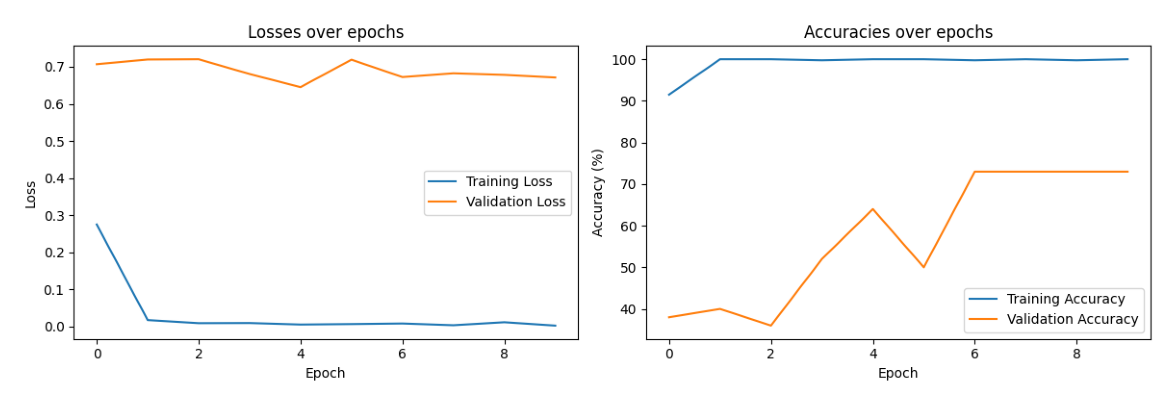

In [ ]:
# Load and display the final epoch's metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('training_metrics_epoch_9.png')  # Assuming 10 epochs (0-9)
plt.figure(figsize=(15,5))
plt.imshow(img)
plt.axis('off')
plt.show()

# Sample Prediction

In [ ]:
def predict_image(image_path, model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.IMAGENET1K_V1)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model.to(device)
    model.eval()

    # Transform image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((600, 600), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        prob = torch.softmax(output, 1)

    result = 'Fake' if predicted.item() == 1 else 'Real'
    confidence = prob[0][predicted.item()].item() * 100

    return result, confidence

# Usage
result, confidence = predict_image('/content/drive/MyDrive/deepfake/test/real/311.png', 'efficientnet_b7_best_model.pth')
print(f'Prediction: {result} (Confidence: {confidence:.2f}%)')

<ipython-input-8-cacadf52dcb6>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


Prediction: Real (Confidence: 75.49%)


# Confusion Matrix

<ipython-input-9-dea8b64fcbe4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('efficientnet_b7_best_model.pth')['model_state_dict'])
Eval

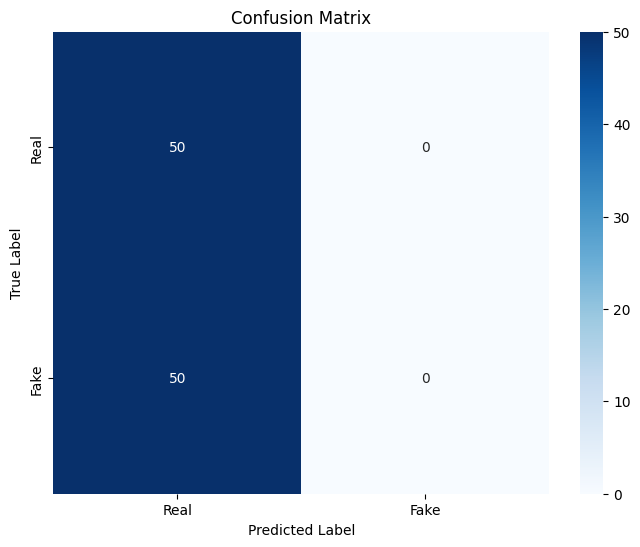


Classification Report:
              precision    recall  f1-score   support

        Real       0.50      1.00      0.67        50
        Fake       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.images = []
        self.labels = []

        real_dir = os.path.join(test_dir, 'real')
        for img_name in os.listdir(real_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(real_dir, img_name))
                self.labels.append(0)

        fake_dir = os.path.join(test_dir, 'fake')
        for img_name in os.listdir(fake_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(fake_dir, img_name))
                self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label


def evaluate_model():
    # Data transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((600, 600), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create test dataset and loader
    test_dataset = TestDataset(test_dataset_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.IMAGENET1K_V1)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    model.load_state_dict(torch.load('efficientnet_b7_best_model.pth')['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Get predictions
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

if __name__ == "__main__":
    # Example usage
    evaluate_model()  # For confusion matrix and metrics
